In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
pd.options.mode.chained_assignment = None

In [4]:
#Since data is in form of excel file we have to use pandas read_excel to load the data
train_data=pd.read_excel('C:/Users/tan/Desktop/Python(DataScience)/PredicFareOfAirlinesTickets/Data_Train.xlsx')
train_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [5]:
train_data.shape

(10683, 11)

In [6]:
train_data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
train_data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [8]:
# The function converts data to a datetime
def change_into_datetime(col):
    train_data[col]=pd.to_datetime(train_data[col])

In [9]:
train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [10]:
for i in ['Date_of_Journey','Dep_Time','Arrival_Time']:
    change_into_datetime(i)

In [11]:
train_data.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [12]:
train_data['day'] = train_data['Date_of_Journey'].dt.day
train_data['month'] = train_data['Date_of_Journey'].dt.month
train_data['year'] = train_data['Date_of_Journey'].dt.year

In [13]:
# Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.
train_data.drop('Date_of_Journey',axis = 1, inplace = True)

In [14]:
train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,month,year
0,IndiGo,Banglore,New Delhi,BLR → DEL,2021-05-06 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-05-06 05:50:00,2021-05-06 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2021-05-06 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2021-05-06 18:05:00,2021-05-06 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2021-05-06 16:50:00,2021-05-06 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019


In [15]:
# The function extract to hour
def extract_hour(df, col):
    df[col+'_hour'] = df[col].dt.hour
# The function extract to minute
def extract_min(df, col):
    df[col+'_minute'] = df[col].dt.minute
# The function drop a column
def drop_col(df,col):
    df.drop(col, axis = 1, inplace = True)

In [16]:
# Extracting Hours
extract_hour(train_data,'Dep_Time')
# Extracting Minutes
extract_min(train_data,'Dep_Time')
# Drop Column Dep_time
drop_col(train_data,'Dep_Time')

In [17]:
train_data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,month,year,Dep_Time_hour,Dep_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-05-06 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2021-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2021-05-06 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2021-05-06 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019,16,50


In [18]:
# Extracting Hours
extract_hour(train_data,'Arrival_Time')
# Extracting Minutes
extract_min(train_data,'Arrival_Time')
# Drop column Arrival_Time
drop_col(train_data,'Arrival_Time')

In [19]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35


In [20]:
# Initialize the list containing the Duration column.
duration = list(train_data['Duration'])
# Check in the Duration column.
for i in range(len(duration)):
    if len(duration[i].split(' ')) == 2:
        pass
    else:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

In [21]:
train_data['Duration'] = duration
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35


In [22]:
# The function returns Hours
def hour(x):
    return x.split(' ')[0][0:-1]
# The function returns Minutes
def minute(x):
    return x.split(' ')[1][0:-1]

In [23]:
train_data['Duration_hour'] = train_data['Duration'].apply(hour)
train_data['Duration_minute'] = train_data['Duration'].apply(minute)

In [24]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45


In [25]:
drop_col(train_data,'Duration')

In [26]:
train_data.dtypes

Airline                object
Source                 object
Destination            object
Route                  object
Total_Stops            object
Additional_Info        object
Price                   int64
day                     int64
month                   int64
year                    int64
Dep_Time_hour           int64
Dep_Time_minute         int64
Arrival_Time_hour       int64
Arrival_Time_minute     int64
Duration_hour          object
Duration_minute        object
dtype: object

In [27]:
train_data['Duration_hour']  = train_data['Duration_hour'].astype(int)
train_data['Duration_minute']  = train_data['Duration_minute'].astype(int)

In [28]:
train_data.dtypes

Airline                object
Source                 object
Destination            object
Route                  object
Total_Stops            object
Additional_Info        object
Price                   int64
day                     int64
month                   int64
year                    int64
Dep_Time_hour           int64
Dep_Time_minute         int64
Arrival_Time_hour       int64
Arrival_Time_minute     int64
Duration_hour           int32
Duration_minute         int32
dtype: object

In [29]:
cat_col = [col for col in train_data.columns if train_data[col].dtype=='object']
cat_col

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [30]:
cont_col = [col for col in train_data.columns if train_data[col].dtype!='object']
cont_col

['Price',
 'day',
 'month',
 'year',
 'Dep_Time_hour',
 'Dep_Time_minute',
 'Arrival_Time_hour',
 'Arrival_Time_minute',
 'Duration_hour',
 'Duration_minute']

In [31]:
categorical = train_data[cat_col]
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info


In [32]:
categorical['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

<AxesSubplot:xlabel='Airline', ylabel='Price'>

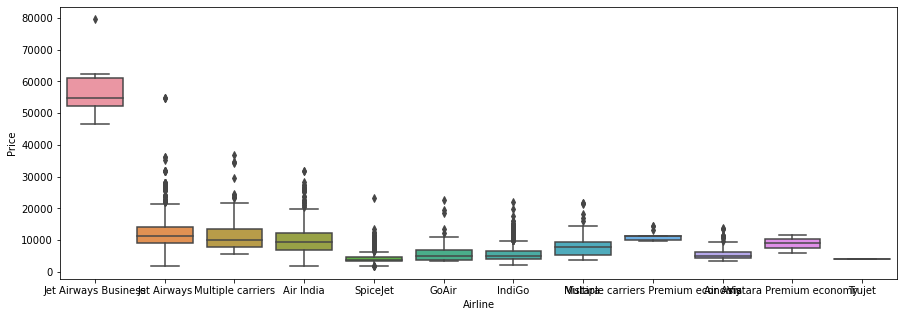

In [33]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'Airline',y = 'Price', data = train_data.sort_values('Price', ascending = False))

In [34]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45


<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

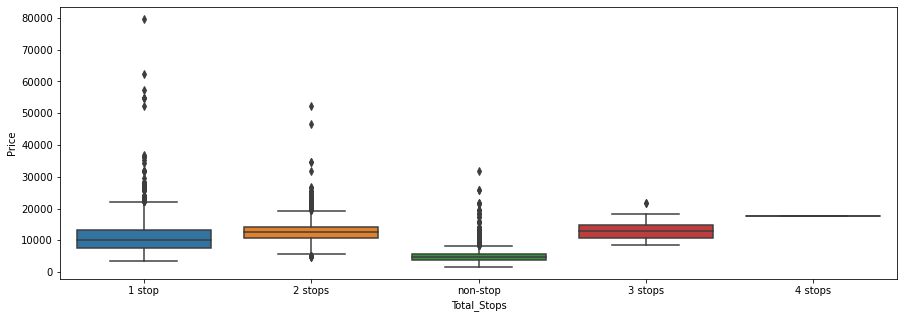

In [35]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'Total_Stops',y = 'Price', data = train_data.sort_values('Price', ascending = False))

In [36]:
Airline = pd.get_dummies(categorical['Airline'], drop_first = True)
Airline.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [37]:
categorical['Source'].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

<AxesSubplot:xlabel='Source', ylabel='Price'>

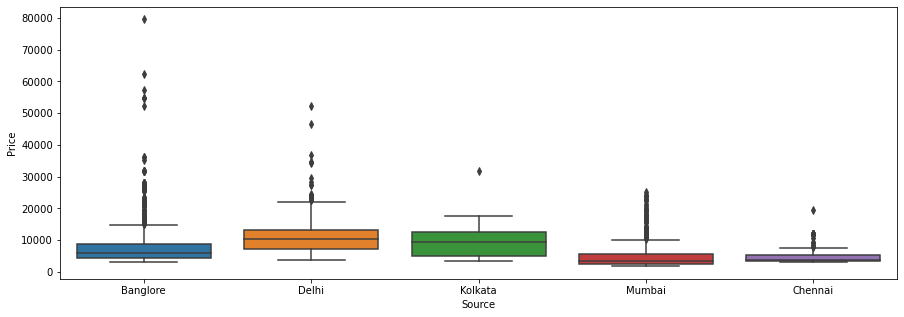

In [38]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'Source',y = 'Price', data = train_data.sort_values('Price', ascending = False))

In [39]:
Source = pd.get_dummies(categorical['Source'], drop_first = True)
Source.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [40]:
categorical['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='Price'>

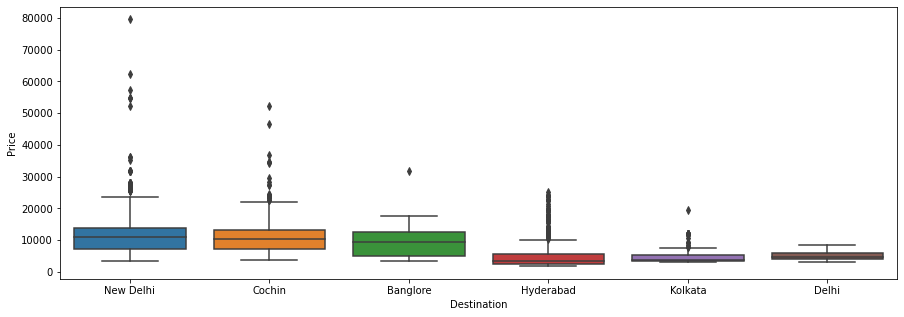

In [41]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'Destination',y = 'Price', data = train_data.sort_values('Price', ascending = False))

In [42]:
Destination = pd.get_dummies(categorical['Destination'], drop_first = True)
Destination.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [43]:
categorical['Route_1'] = categorical['Route'].str.split('→').str[0]
categorical['Route_2'] = categorical['Route'].str.split('→').str[1]
categorical['Route_3'] = categorical['Route'].str.split('→').str[2]
categorical['Route_4'] = categorical['Route'].str.split('→').str[3]
categorical['Route_5'] = categorical['Route'].str.split('→').str[4]

In [44]:
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [45]:
drop_col(categorical,'Route')

In [46]:
categorical.isnull().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            1
Additional_Info        0
Route_1                1
Route_2                1
Route_3             3492
Route_4             9117
Route_5            10637
dtype: int64

In [47]:
categorical.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'],
      dtype='object')

In [48]:
for i in ['Total_Stops','Route_1','Route_2','Route_3','Route_4','Route_5']:
    categorical[i].fillna('None', inplace = True)

In [49]:
categorical.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Additional_Info    0
Route_1            0
Route_2            0
Route_3            0
Route_4            0
Route_5            0
dtype: int64

In [50]:
for i in categorical.columns:
    print('{} has total {} categories'.format(i, len(categorical[i].value_counts())))

Airline has total 12 categories
Source has total 5 categories
Destination has total 6 categories
Total_Stops has total 6 categories
Additional_Info has total 10 categories
Route_1 has total 6 categories
Route_2 has total 46 categories
Route_3 has total 30 categories
Route_4 has total 14 categories
Route_5 has total 6 categories


In [51]:
encoder = LabelEncoder()

In [52]:
for i in ['Route_1','Route_2','Route_3','Route_4','Route_5']:
    categorical[i] = encoder.fit_transform(categorical[i])

In [53]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,non-stop,No info,0,13,29,13,5
1,Air India,Kolkata,Banglore,2 stops,No info,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2 stops,No info,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1 stop,No info,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1 stop,No info,0,34,8,13,5


In [54]:
drop_col(categorical,'Additional_Info')

In [55]:
categorical['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', 'None', '4 stops'],
      dtype=object)

In [56]:
dict = {'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4,'None':5}

In [57]:
categorical['Total_Stops'] = categorical['Total_Stops'].map(dict)

In [58]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5
1,Air India,Kolkata,Banglore,2,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5


In [59]:
data_train = pd.concat([categorical,Airline,Source,Destination,train_data[cont_col]],axis =1)

In [60]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,...,Price,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5,0,...,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,2,25,1,3,5,1,...,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5,0,...,13882,6,9,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5,0,...,6218,5,12,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5,0,...,13302,3,1,2019,16,50,21,35,4,45


In [61]:
drop_col(data_train,'Airline')
drop_col(data_train,'Source')
drop_col(data_train,'Destination')

In [62]:
data_train.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,...,Price,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,0,0,13,29,13,5,0,0,1,0,...,3897,24,3,2019,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,...,7662,5,1,2019,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,...,13882,6,9,2019,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,...,6218,5,12,2019,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,...,13302,3,1,2019,16,50,21,35,4,45


In [63]:
pd.set_option('display.max_columns',50)
data_train.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,24,3,2019,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,5,1,2019,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,6,9,2019,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,5,12,2019,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,3,1,2019,16,50,21,35,4,45


In [64]:
def plot(df, col):
    fig,(ax1, ax2) = plt.subplots(2,1)
    sns.distplot(df[col], ax = ax1)
    sns.boxplot(df[col],ax = ax2)

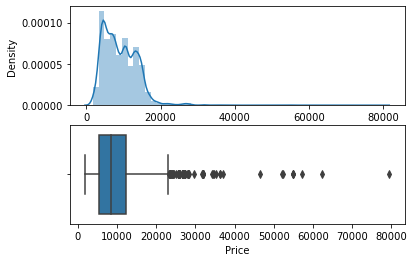

In [65]:
plot(data_train,'Price')

In [66]:
data_train['Price']=np.where(data_train['Price']>=40000,data_train['Price'].median(),data_train['Price'])

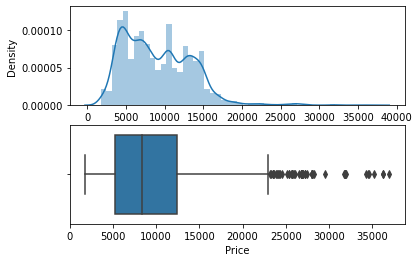

In [67]:
plot(data_train,'Price')

In [68]:
X = data_train.drop('Price', axis=1)

In [69]:
X.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,day,month,year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24,3,2019,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,1,2019,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,6,9,2019,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,12,2019,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,2019,16,50,21,35,4,45


In [70]:
y = data_train['Price']
y

0         3897.0
1         7662.0
2        13882.0
3         6218.0
4        13302.0
          ...   
10678     4107.0
10679     4145.0
10680     7229.0
10681    12648.0
10682    11753.0
Name: Price, Length: 10683, dtype: float64

In [71]:
mutual_info_classif(X,y)

array([2.14711730e+00, 2.04574710e+00, 2.79400260e+00, 2.28861524e+00,
       1.51395270e+00, 7.07837692e-01, 7.36693730e-01, 1.13941001e-01,
       6.68529774e-01, 9.17126052e-01, 8.22630484e-05, 5.61459020e-01,
       1.71254934e-02, 3.14048423e-01, 0.00000000e+00, 2.15676734e-01,
       5.09605180e-03, 1.59106870e-01, 1.57849088e+00, 8.72267813e-01,
       2.88554100e-01, 1.50639560e+00, 4.00900332e-01, 2.92760826e-01,
       1.62334435e-01, 3.93811296e-01, 1.09125059e+00, 8.33836221e-01,
       1.47389576e+00, 1.41168045e+00, 1.18365406e+00, 1.84285702e+00,
       1.53351828e+00, 1.78527300e+00, 1.06162962e+00])

In [72]:
imp = pd.DataFrame(mutual_info_classif(X,y),index = X.columns)
imp

,0
Total_Stops,2.153861
Route_1,2.002317
Route_2,2.798603
Route_3,2.264859
Route_4,1.478484
Route_5,0.689273
Air India,0.773177
GoAir,0.101341
IndiGo,0.670101
Jet Airways,0.913782


In [73]:
imp.columns = ['importance']
imp.sort_values(by='importance',  ascending = False)

,importance
Route_2,2.798603
Route_3,2.264859
Total_Stops,2.153861
Route_1,2.002317
Arrival_Time_hour,1.831014
Duration_hour,1.826965
Cochin,1.557172
Delhi,1.546756
Arrival_Time_minute,1.518205
Route_4,1.478484


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [75]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [78]:
def predict(ml_model, dump):
    model=ml_model()
    model.fit(X_train,y_train)
    print('Training score : {}'.format(model.score(X_train,y_train)))
    y_prediction=model.predict(X_test)
    print('predictions are: \n {}'.format(y_prediction))
    print('\n')
    r2_score=metrics.r2_score(y_test,y_prediction)
    print('r2 score: {}'.format(r2_score))
    print('MAE:',metrics.mean_absolute_error(y_test,y_prediction))
    print('MSE:',metrics.mean_squared_error(y_test,y_prediction))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_prediction)))
    sns.distplot(y_test-y_prediction)
    if dump==1:
        file = open('C:/Users/tan/Desktop/Python(DataScience)/PredicFareOfAirlinesTickets/model.pkl','wb')
        pickle.dump(model,file)

Training score : 0.9541975312252239
predictions are: 
 [12625.61666667 12516.9225      5770.9        ...  7283.32
  4812.71        7158.64      ]


r2 score: 0.8118337808158401
MAE: 1159.2507692183551
MSE: 3586608.4664086546
RMSE: 1893.8343291873907


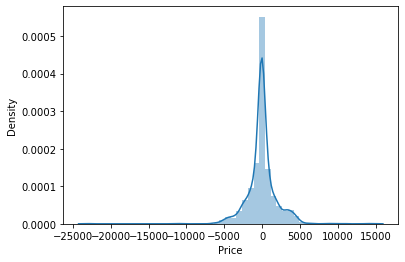

In [79]:
predict(RandomForestRegressor,1)

Training score : 0.9680046974365047
predictions are: 
 [14781.  13963.5  5895.  ...  7215.   4823.   7670. ]


r2 score: 0.6822240652533151
MAE: 1337.8812977694586
MSE: 6057080.080181198
RMSE: 2461.1135853879637


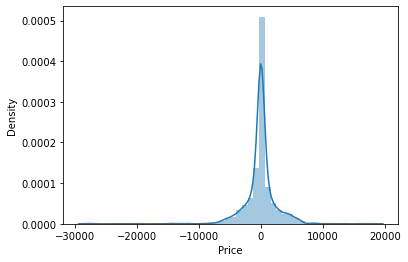

In [80]:
predict(DecisionTreeRegressor,0)

Training score : 0.616614368244482
predictions are: 
 [11315.08372236 11707.62583775  4310.7449442  ...  9920.70428034
  4193.95173453 10596.17949531]


r2 score: 0.6116068514852815
MAE: 1927.4476751642542
MSE: 7403104.344646734
RMSE: 2720.864631812236


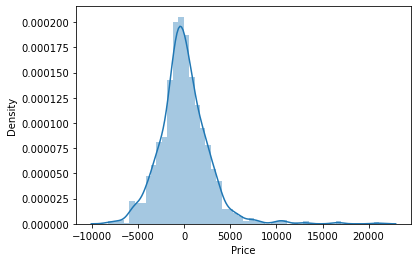

In [81]:
predict(LinearRegression,0)

In [82]:
n_estimators=[int(x) for x in np.linspace(start=100,stop=1200,num=6)]

In [83]:
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(5,30,num=4)]
min_samples_split=[5,10,15,100]

In [84]:
random_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
'max_depth':max_depth,
    'min_samples_split':min_samples_split
}
random_grid

{'n_estimators': [100, 320, 540, 760, 980, 1200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 13, 21, 30],
 'min_samples_split': [5, 10, 15, 100]}

In [85]:
reg_rf=RandomForestRegressor()
rf_random=RandomizedSearchCV(estimator=reg_rf,param_distributions=random_grid,cv=3,verbose=2,n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [86]:
rf_random.best_params_

{'n_estimators': 540,
 'min_samples_split': 15,
 'max_features': 'auto',
 'max_depth': 21}

<AxesSubplot:xlabel='Price', ylabel='Density'>

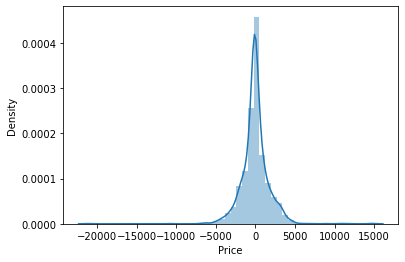

In [87]:
prediction=rf_random.predict(X_test)
sns.distplot(y_test-prediction)

In [88]:
metrics.r2_score(y_test,prediction)

0.8433561190756828

In [89]:
print('MAE',metrics.mean_absolute_error(y_test,prediction))
print('MSE',metrics.mean_squared_error(y_test,prediction))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE 1106.5717119540825
MSE 2985765.8402776704
RMSE 1727.936873927306


In [90]:
file = open('C:/Users/tan/Desktop/Python(DataScience)/PredicFareOfAirlinesTickets/rf_random.pkl','wb')

In [91]:
pickle.dump(rf_random,file)

In [92]:
model =open('C:/Users/tan/Desktop/Python(DataScience)/PredicFareOfAirlinesTickets/model.pkl','rb')
forest=pickle.load(model)

In [93]:
prediction2=forest.predict(X_test)

In [94]:
prediction2

array([12625.61666667, 12516.9225    ,  5770.9       , ...,
        7283.32      ,  4812.71      ,  7158.64      ])

In [95]:
metrics.r2_score(y_test,prediction2)

0.8118337808158401